<a href="https://colab.research.google.com/github/ArianAmani/scFoundation-GeneKnockOut/blob/main/notebooks/scFound_Geneformer_KO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!rm -rf scFoundation-GeneKnockOut
!git clone https://github.com/ArianAmani/scFoundation-GeneKnockOut.git
%cd scFoundation-GeneKnockOut
!pip install helical
!pip install -e .
%cd ..

In [ ]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=ImportWarning)
warnings.filterwarnings('ignore')

import scanpy as sc
import anndata as an
import random

from scFoundGPert import (
    scFoundGPert,
    plot_metrics,
    CellEmbeddingClassifier,
)
from scFoundGPert.data_handler import add_perturbed_cells

In [ ]:
adata = sc.read(
    "kang_counts_25k.h5ad", backup_url="https://figshare.com/ndownloader/files/34464122"
)
adata
del adata.obsm['X_pca']
del adata.obsm['X_umap']

adata = adata[adata.obs['cell_type'] != 'Megakaryocytes'].copy()
adata = adata[adata.obs['cell_type'] != 'Dendritic cells'].copy()

In [ ]:
adata

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AnnData object with n_obs × n_vars = 24012 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters'
    var: 'name'

In [ ]:
adata.X.min(), adata.X.max()

(0.0, 3828.0)

In [ ]:
adata.layers['counts'] = adata.X.copy()

sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

# Finding highly variable genes using count data
sc.pp.highly_variable_genes(
    adata, n_top_genes=7000, subset=True,
)

adata.X = adata.layers['counts'].copy()
del adata.layers['counts']
adata

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


AnnData object with n_obs × n_vars = 24011 × 7000
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters', 'n_genes'
    var: 'name', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [ ]:
adata.var.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bo

,name,n_cells,highly_variable,means,dispersions,dispersions_norm
index,,,,,,
AL627309.1,AL627309.1,6,True,0.000306,0.355674,0.723685
LINC00115,LINC00115,87,True,0.003622,0.335490,0.648795
NOC2L,NOC2L,1455,True,0.061249,0.213654,0.196741
HES4,HES4,2162,True,0.097196,0.530996,1.374191
RP11-54O7.11,RP11-54O7.11,3,True,0.000123,0.219381,0.217991


In [ ]:
gene_candidates = [
    "STAT1", "STAT2", "IRF7", "IRF9", "JAK1", "JAK2",
    "IFITM1", "IFITM2", "IFITM3", "MX1", "OAS1", "IL6", "IL10"
]
available_genes = []
for gene in gene_candidates:
    if gene in adata.var.index:
        print(gene)
        available_genes.append(gene)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


STAT1
IRF9
IFITM3
IL6


In [ ]:
perturbs = [
    "STAT1",
    "IRF9",
    "IFITM3",
    "IL6",
    "STAT1+IRF9",
    "STAT1+IFITM3",
    "STAT1+IL6",
    "IRF9+IFITM3",
    "IRF9+IL6",
    "IFITM3+IL6",
    "STAT1+IRF9+IFITM3",
    "STAT1+IRF9+IL6",
    "STAT1+IFITM3+IL6",
    "IRF9+IFITM3+IL6",
    "STAT1+IRF9+IFITM3+IL6",
]

In [ ]:
adata_with_perturbations = add_perturbed_cells(
    adata,
    genes=perturbs,
    gene_name_key=None,
    perturb_value=0,
    perturbation_key='label',
    control='ctrl',
    # subsample=5000,
)
adata_with_perturbations.obs['label'] = adata_with_perturbations.obs['label'].astype('category')
adata_with_perturbations.obs['n_counts'] = adata_with_perturbations.X.sum(axis=1)

In [ ]:
adata_with_perturbations.obs['label'].value_counts()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,count
label,
stim,12018
ctrl,11993
IFITM3,1270
STAT1,872
IRF9,609
STAT1+IFITM3,267
IRF9+IFITM3,98
STAT1+IRF9,68
STAT1+IRF9+IFITM3,25


In [ ]:
adata_with_perturbations.X.min(), adata_with_perturbations.X.max()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0.0, 3828.0)

In [ ]:
config_kwargs = {
    "model_name": "gf-6L-30M-i2048",
    "emb_mode": "cell",
}
model = scFoundGPert('Geneformer', device='cuda', batch_size=32, config_kwargs=config_kwargs)

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


In [ ]:
data = model.process_data(adata_with_perturbations)
adata_with_perturbations.obsm['X_Geneformer'] = model.get_embeddings(data)

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


Map:   0%|          | 0/27243 [00:00<?, ? examples/s]

  0%|          | 0/852 [00:00<?, ?it/s]

In [ ]:
import gc
import torch
torch.cuda.empty_cache()
gc.collect()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


4241

In [ ]:
sc.pp.neighbors(adata_with_perturbations, use_rep="X_Geneformer", metric='cosine')
sc.tl.umap(adata_with_perturbations)

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen impo

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bo

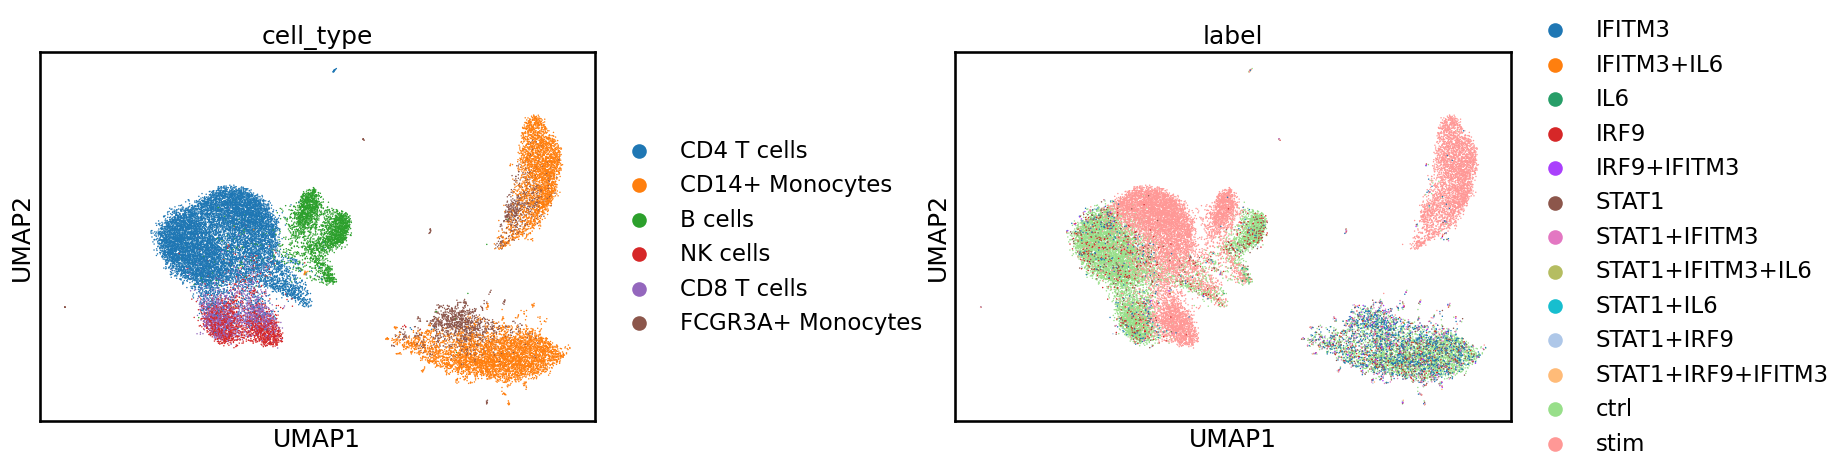

In [ ]:
sc.pl.umap(
    adata_with_perturbations,
    color=['cell_type', 'label'],
    wspace=0.5,
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


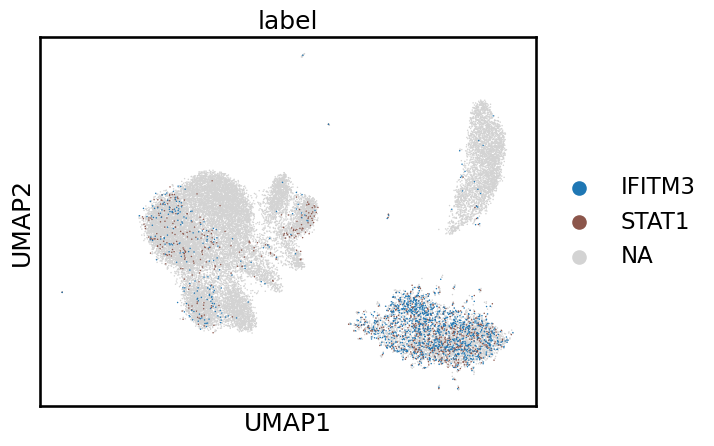

In [ ]:
sc.pl.umap(
    adata_with_perturbations,
    color='label',
    groups=['STAT1', 'IFITM3'],
    wspace=0.5,
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-pack

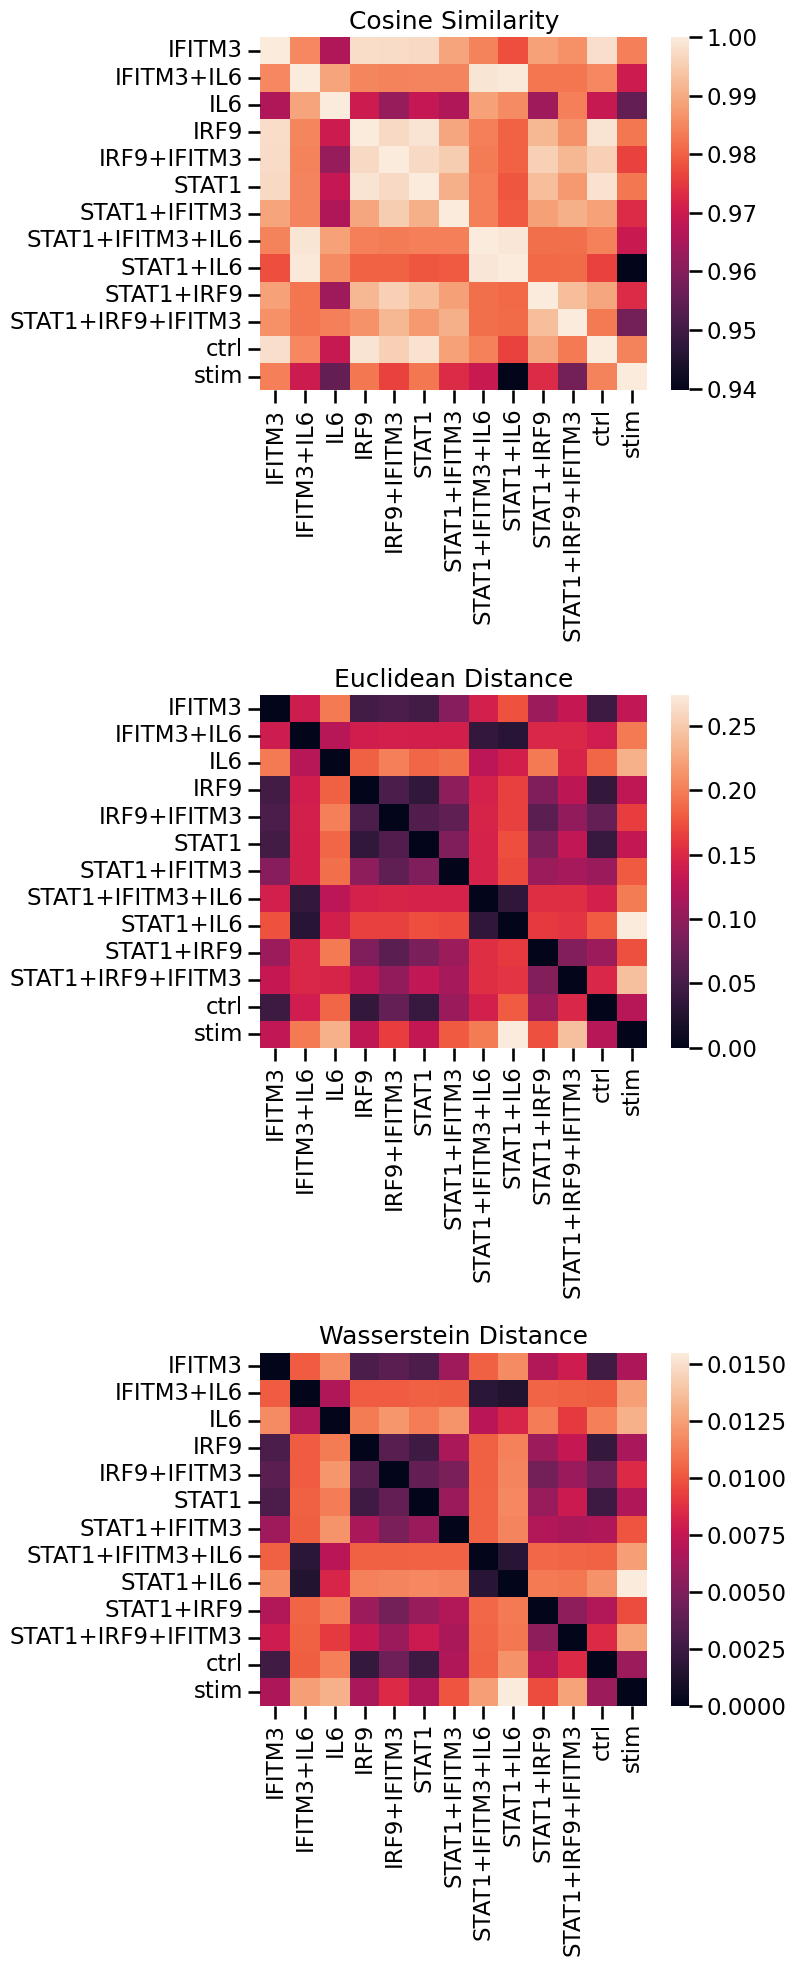

In [ ]:
metrics_for_each_ct = plot_metrics(
    adata_with_perturbations,
    obsm_key='X_Geneformer',
    perturbation_key='label',
    cell_type_key='cell_type',
)

In [ ]:
adata_with_perturbations.obs['label'].value_counts()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,count
label,
stim,12018
ctrl,11993
IFITM3,1270
STAT1,872
IRF9,609
STAT1+IFITM3,267
IRF9+IFITM3,98
STAT1+IRF9,68
STAT1+IRF9+IFITM3,25


In [ ]:
(adata_with_perturbations.obs['label'].value_counts() > 10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,count
label,
stim,True
ctrl,True
IFITM3,True
STAT1,True
IRF9,True
STAT1+IFITM3,True
IRF9+IFITM3,True
STAT1+IRF9,True
STAT1+IRF9+IFITM3,True


In [ ]:
# Count the occurrences of each label
label_counts = adata_with_perturbations.obs['label'].value_counts()

# Identify labels with more than 10 occurrences
valid_labels = label_counts[label_counts > 10].index

adata_to_classify = adata_with_perturbations[adata_with_perturbations.obs['label'].isin(valid_labels)].copy()
adata_to_classify

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 27239 × 7000
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters', 'n_genes', 'n_counts', 'total_counts'
    var: 'index', 'ensembl_id', 'gene_ids_collapsed'
    uns: 'neighbors', 'umap', 'cell_type_colors', 'label_colors'
    obsm: 'X_Geneformer', 'X_umap'
    obsp: 'distances', 'connectivities'

In [ ]:
adata_to_classify.obs['label'].value_counts()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,count
label,
stim,12018
ctrl,11993
IFITM3,1270
STAT1,872
IRF9,609
STAT1+IFITM3,267
IRF9+IFITM3,98
STAT1+IRF9,68
STAT1+IRF9+IFITM3,25


In [ ]:
cell_clf = CellEmbeddingClassifier(
    adata_to_classify,
    obsm_key='X_Geneformer',
    perturbation_key='label',
    classifier="mlp",
    classif_params={
        'device': 'cuda',
        'epochs': 100,
        'batch_size': 256,
        'dropout': 0.3,
        'n_layers': 3,
        'hidden_dim': 256,
    },
)

cell_clf.train()

report = cell_clf.evaluate()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Epoch [1/100],                     Loss: 0.6747431100107902
Epoch [2/100],                     Loss: 0.45246234605478686
Epoch [3/100],                     Loss: 0.40031087727740755
Epoch [4/100],                     Loss: 0.3802885669608449
Epoch [5/100],                     Loss: 0.3659943810036016
Epoch [6/100],                     Loss: 0.34903930543467054
Epoch [7/100],                     Loss: 0.34245128219210824
Epoch [8/100],                     Loss: 0.33896365415218266
Epoch [9/100],                     Loss: 0.33710374094026035
Epoch [10/100],                     Loss: 0.3293360033354094
Epoch [11/100],                     Loss: 0.3192022872525592
Epoch [12/100],                     Loss: 0.3198422015059826
Epoch [13/100],                     Loss: 0.3100504743498425
Epoch [14/100],                     Loss: 0.30733576243699984
Epoch [15/100],                     Loss: 0.29954739348139875
Epoch [16/100],                     Loss: 0.29697428713011187
Epoch [17/100],         

In [ ]:
cell_clf = CellEmbeddingClassifier(
    adata_to_classify,
    obsm_key='X_Geneformer',
    perturbation_key='label',
    classifier="dt",
)

cell_clf.train()

report = cell_clf.evaluate()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


                   precision    recall  f1-score   support

           IFITM3       0.08      0.11      0.09       254
              IL6       0.00      0.00      0.00         4
             IRF9       0.03      0.03      0.03       122
      IRF9+IFITM3       0.00      0.00      0.00        20
            STAT1       0.05      0.05      0.05       174
     STAT1+IFITM3       0.04      0.04      0.04        53
       STAT1+IRF9       0.00      0.00      0.00        13
STAT1+IRF9+IFITM3       0.00      0.00      0.00         5
             ctrl       0.70      0.66      0.68      2399
             stim       0.84      0.84      0.84      2404

         accuracy                           0.67      5448
        macro avg       0.17      0.17      0.17      5448
     weighted avg       0.68      0.67      0.68      5448



In [ ]:
cell_clf = CellEmbeddingClassifier(
    adata_to_classify,
    obsm_key='X_Geneformer',
    perturbation_key='label',
    classifier="rf",
)

cell_clf.train()

report = cell_clf.evaluate()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bo

                   precision    recall  f1-score   support

           IFITM3       0.00      0.00      0.00       254
              IL6       0.00      0.00      0.00         4
             IRF9       0.00      0.00      0.00       122
      IRF9+IFITM3       0.00      0.00      0.00        20
            STAT1       0.00      0.00      0.00       174
     STAT1+IFITM3       0.00      0.00      0.00        53
       STAT1+IRF9       0.00      0.00      0.00        13
STAT1+IRF9+IFITM3       0.00      0.00      0.00         5
             ctrl       0.76      0.93      0.83      2399
             stim       0.97      0.93      0.95      2404

         accuracy                           0.82      5448
        macro avg       0.17      0.19      0.18      5448
     weighted avg       0.76      0.82      0.79      5448



In [ ]:
cell_clf = CellEmbeddingClassifier(
    adata_to_classify,
    obsm_key='X_Geneformer',
    perturbation_key='label',
    classifier="svm",
)

cell_clf.train()

report = cell_clf.evaluate()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


                   precision    recall  f1-score   support

           IFITM3       0.27      0.03      0.05       254
              IL6       0.00      0.00      0.00         4
             IRF9       0.00      0.00      0.00       122
      IRF9+IFITM3       0.00      0.00      0.00        20
            STAT1       0.00      0.00      0.00       174
     STAT1+IFITM3       0.00      0.00      0.00        53
       STAT1+IRF9       0.00      0.00      0.00        13
STAT1+IRF9+IFITM3       0.00      0.00      0.00         5
             ctrl       0.77      0.98      0.86      2399
             stim       0.98      0.96      0.97      2404

         accuracy                           0.86      5448
        macro avg       0.20      0.20      0.19      5448
     weighted avg       0.78      0.86      0.81      5448



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
cell_clf = CellEmbeddingClassifier(
    adata_to_classify,
    obsm_key='X_Geneformer',
    perturbation_key='label',
    classifier="mlp",
    classif_params={
        'device': 'cuda',
        'epochs': 100,
        'batch_size': 256,
        'dropout': 0.3,
        'n_layers': 2,
        'hidden_dim': 256,
    },
)

cell_clf.train()

report = cell_clf.evaluate()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Epoch [1/100],                     Loss: 0.6745044426169506
Epoch [2/100],                     Loss: 0.43437499847523003
Epoch [3/100],                     Loss: 0.39724610676599104
Epoch [4/100],                     Loss: 0.37315176150133444
Epoch [5/100],                     Loss: 0.36053831927305047
Epoch [6/100],                     Loss: 0.35546309830144396
Epoch [7/100],                     Loss: 0.3476445586528889
Epoch [8/100],                     Loss: 0.3348320301535518
Epoch [9/100],                     Loss: 0.3305427198146665
Epoch [10/100],                     Loss: 0.32862651573364127
Epoch [11/100],                     Loss: 0.31638328453829123
Epoch [12/100],                     Loss: 0.31575192112562267
Epoch [13/100],                     Loss: 0.3088530463188194
Epoch [14/100],                     Loss: 0.3058827846895817
Epoch [15/100],                     Loss: 0.30491007067436393
Epoch [16/100],                     Loss: 0.29801550039718316
Epoch [17/100],        